# Performance analysis experiments

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import re

## 1. Load vs. compute time breakdown

Change directory to `experiments/`. Run the `round_robin.py` script with different arguments for different experiment parameters. Use the `-b` option so that the mock client blocks on each request.

```sh
python round_robin.py [-b] [-m MODEL_NAME] [-n NUM_MODELS] [-t TP_WORLD_SIZE] [-p PP_WORLD_SIZE] [-r NUM_REQUESTS]
```

Then run the cells below with `debug = False` to extract time data from logs.

For reference, Perlmutter GPU nodes have 4x A100 40GB GPUs per mode, each with a PCIe 4.0 x16 CPU-GPU link that has 32 GB/s bandwidth.

### 1.1. Scaling number of GPUs

In [2]:
cwd = globals()['_dh'][0]
debug = True
if debug:
    # Experiment parameters to debug this notebook
    model_name = "opt-6.7b"
    parallel_configs = [(1, 1), (2, 1), (2, 1), (1, 2), (1, 2), (1, 1)]
else:
    # True experiment parameters
    model_name = "opt-13b"
    parallel_configs = [(1, 1), (2, 1), (4, 1), (1, 2), (1, 4), (2, 2)]
num_models = 2
num_requests = 24

def get_log_dir(tp, pp):
    s = "rr"
    s += f"_{model_name}"
    s += f"_n{num_models}"
    s += f"_t{tp}"
    s += f"_p{pp}"
    s += f"_r{num_requests}"
    s += "_b"
    return join(cwd, s)


def round_robin_times(tp=1, pp=1):
    offload_times = []
    load_times = []
    model_times = []
    total_times = []

    log_dir = get_log_dir(tp, pp)
    with open(join(log_dir, "rank_0_master.log"), "r") as file:
        for line in file:
            if "loaded: False" in line:
                t = re.search(r"time: (\d+\.\d+)", line).group(1)
                offload_times.append(float(t))
            elif "loaded: True" in line:
                t = re.search(r"time: (\d+\.\d+)", line).group(1)
                load_times.append(float(t))
            elif "batch size" in line:
                t = re.search(r"time: (\d+\.\d+)", line).group(1)
                model_times.append(float(t))
    
    with open(join(log_dir, "client.log")) as file:
        for line in file:
            t = re.search(r"time: (\d+\.\d+)", line).group(1)
            total_times.append(float(t))

    # Remove warm up requests
    return (
        offload_times[3:],
        load_times[4:],
        model_times[4:],
        total_times[4:],
    )


[[1.38035    1.42415    0.225      1.65707585]
 [0.8077     0.8289     0.3866     1.22600087]
 [0.8077     0.8289     0.3866     1.22600087]
 [0.74125    0.7665     0.20505    0.98003519]
 [0.74125    0.7665     0.20505    0.98003519]
 [1.38035    1.42415    0.225      1.65707585]]


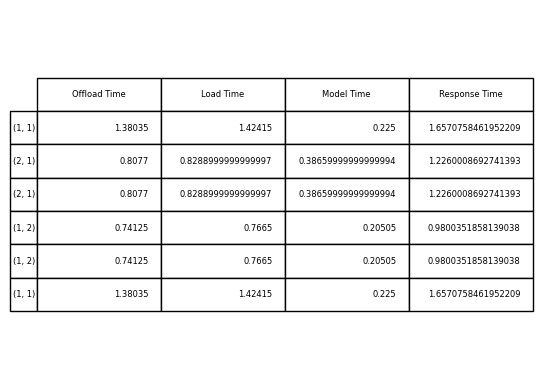

In [3]:
times = []
for pc in parallel_configs:
    times.append(round_robin_times(*pc))

times = np.array(times) # (parallel_config, timer, request)
mean_times = np.mean(times, axis=2)
print(mean_times)

rows = [str(p) for p in parallel_configs]
cols = ["Offload Time", "Load Time", "Model Time", "Response Time"]
plt.axis("off")
plt.axis("tight")
tab = plt.table(mean_times, rowLabels=rows, colLabels=cols, loc="center")
tab.scale(1, 2)
plt.show()

#### 1.1.1. Scaling TP

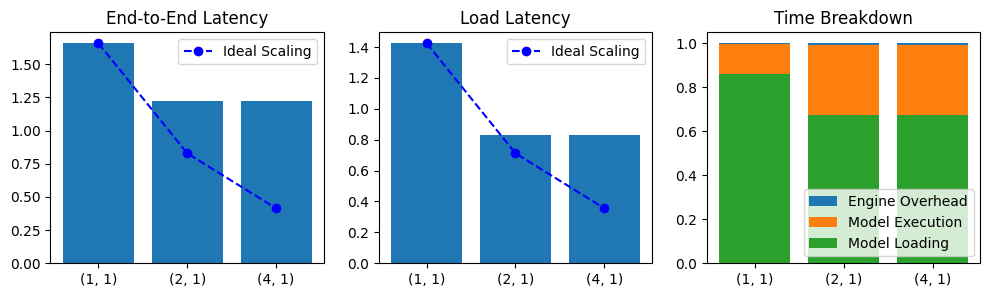

In [4]:
x = ["(1, 1)", "(2, 1)", "(4, 1)"]
mean_scale = mean_times[[0, 1, 2], :]
mean_resp = mean_scale[:, 3]

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].bar(x, mean_resp)
axs[0].plot(x, [mean_resp[0] / i for i in [1, 2, 4]], color="blue", marker="o", linestyle="--", label="Ideal Scaling")
axs[0].set_title("End-to-End Latency")
axs[0].legend()

axs[1].bar(x, mean_scale[:, 1])
axs[1].plot(x, [mean_scale[0, 1] / i for i in [1, 2, 4]], color="blue", marker="o", linestyle="--", label="Ideal Scaling")
axs[1].set_title("Load Latency")
axs[1].legend()

axs[2].bar(x, 1, label="Engine Overhead")
axs[2].bar(x, np.sum(mean_scale[:, 1:3], axis=1) / mean_resp, label="Model Execution")
axs[2].bar(x, mean_scale[:, 1] / mean_resp, label="Model Loading")
axs[2].set_title("Time Breakdown")
axs[2].legend(loc="lower right")

plt.show()

#### 1.1.2. Scaling PP

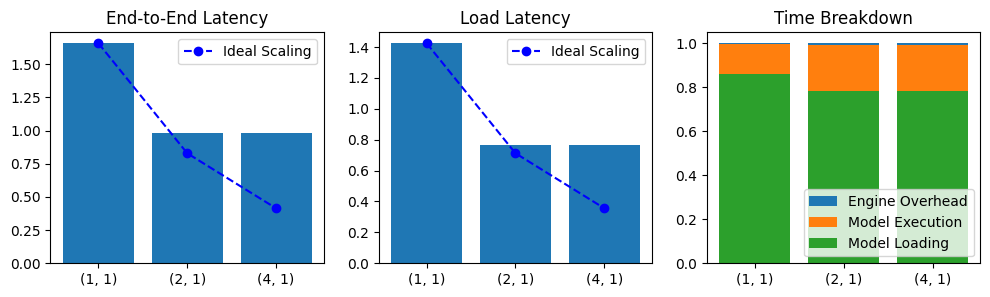

In [5]:
x = ["(1, 1)", "(2, 1)", "(4, 1)"]
mean_scale = mean_times[[0, 3, 4], :]
mean_resp = mean_scale[:, 3]

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].bar(x, mean_resp)
axs[0].plot(x, [mean_resp[0] / i for i in [1, 2, 4]], color="blue", marker="o", linestyle="--", label="Ideal Scaling")
axs[0].set_title("End-to-End Latency")
axs[0].legend()

axs[1].bar(x, mean_scale[:, 1])
axs[1].plot(x, [mean_scale[0, 1] / i for i in [1, 2, 4]], color="blue", marker="o", linestyle="--", label="Ideal Scaling")
axs[1].set_title("Load Latency")
axs[1].legend()

axs[2].bar(x, 1, label="Engine Overhead")
axs[2].bar(x, np.sum(mean_scale[:, 1:3], axis=1) / mean_resp, label="Model Execution")
axs[2].bar(x, mean_scale[:, 1] / mean_resp, label="Model Loading")
axs[2].set_title("Time Breakdown")
axs[2].legend(loc="lower right")

plt.show()